In [1]:
# snr = 2.0, epochs = 30 (#69)
# snr = 1.5, epochs = 5  (#74)
# snr = 1.0, epochs = 5  (#84)

In [2]:
!nvidia-smi
CUDA_VISIBLE_DEVICES=0

Wed Aug 15 19:09:38 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.37                 Driver Version: 396.37                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:05:00.0 Off |                  Off |
| N/A   50C    P0    51W / 250W |   2263MiB / 16160MiB |      9%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  On   | 00000000:84:00.0 Off |                  Off |
| N/A   82C    P0   144W / 250W |  15671MiB / 16160MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
        

In [3]:
import time
import tensorflow as tf
import keras
from keras.layers import CuDNNLSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy.random as rand

from keras import backend as K
import tensorflow as tf
with K.tf.device('/gpu:1'):
    config = tf.ConfigProto(intra_op_parallelism_threads=4,\
           inter_op_parallelism_threads=4, allow_soft_placement=True,\
           device_count = {'CPU' : 1, 'GPU' : 1})
    session = tf.Session(config=config)
    K.set_session(session)

/home/arjung2/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
filename = 'TrainEOB_q-1-10-0.02_ProperWhitenZ.h5'
f = h5py.File(filename, 'r')
a_group_key = list(f.keys())[0]

# Get the data
data = list(f[a_group_key])
y_train = data

filename = 'TestEOB_q-1-10-0.02_ProperWhitenZ.h5'
f = h5py.File(filename, 'r')
a_group_key = list(f.keys())[0]

# Get the data
data = list(f[a_group_key])
y_test = data

print("Number of Training Waves: " + str(len(y_train)))
print("Number of Testing Waves: " + str(len(y_test)))

Number of Training Waves: 9861
Number of Testing Waves: 2459


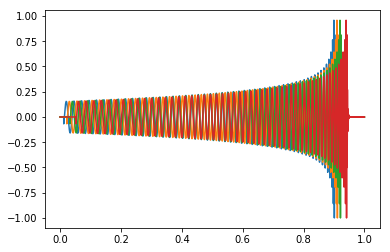

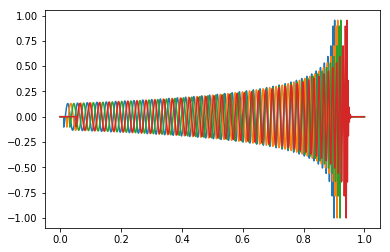

In [5]:
# Shift waves

t = np.linspace(0, 1, 8192)

shift_1 = int(8192 * 0.99)
shift_2 = int(8192 * 0.98)
shift_3 = int(8192 * 0.96)

y_train_1 = []
y_train_2 = []
y_train_3 = []
for i in range(len(y_train)):
    wave_1 = y_train[i][:shift_1]
    wave_1 = np.concatenate((np.zeros(8192 - shift_1), wave_1), axis=0)
    y_train_1.append(wave_1)
    wave_2 = y_train[i][:shift_2]
    wave_2 = np.concatenate((np.zeros(8192 - shift_2), wave_2), axis=0)
    y_train_2.append(wave_2)
    wave_3 = y_train[i][:shift_3]
    wave_3 = np.concatenate((np.zeros(8192 - shift_3), wave_3), axis=0)
    y_train_3.append(wave_3)
    
plt.plot(t, y_train[32])
plt.plot(t, y_train_1[32])
plt.plot(t, y_train_2[32])
plt.plot(t, y_train_3[32])
plt.show()

y_test_1 = []
y_test_2 = []
y_test_3 = []
for i in range(len(y_test)):
    wave_1 = y_test[i][:shift_1]
    wave_1 = np.concatenate((np.zeros(8192 - shift_1), wave_1), axis=0)
    y_test_1.append(wave_1)
    wave_2 = y_test[i][:shift_2]
    wave_2 = np.concatenate((np.zeros(8192 - shift_2), wave_2), axis=0)
    y_test_2.append(wave_2)
    wave_3 = y_test[i][:shift_3]
    wave_3 = np.concatenate((np.zeros(8192 - shift_3), wave_3), axis=0)
    y_test_3.append(wave_3)
    
plt.plot(t, y_test[32])
plt.plot(t, y_test_1[32])
plt.plot(t, y_test_2[32])
plt.plot(t, y_test_3[32])
plt.show()

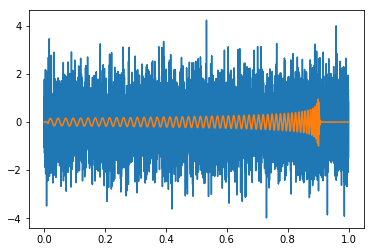

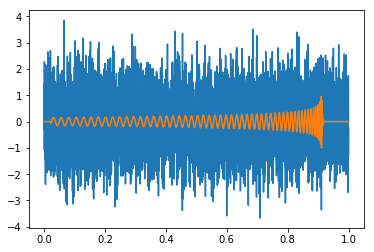

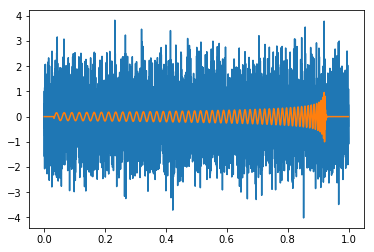

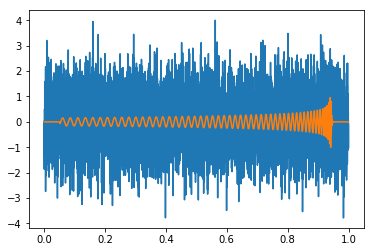

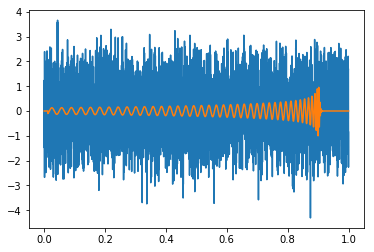

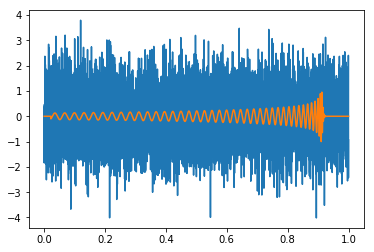

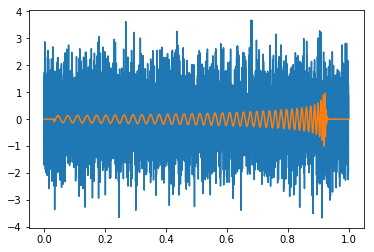

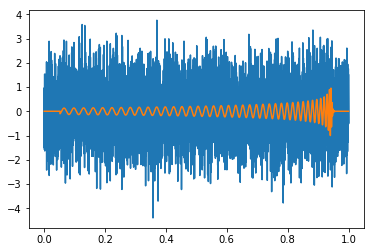

In [6]:
# Add noise

# snr_1 = 1
# snr_2 = 0.9
# snr_3 = 0.8
# snr_4 = 0.7

snr_1 = 1.0
snr_2 = 1.0
snr_3 = 1.0
snr_4 = 1.0

x_train = []
x_train_1 = []
x_train_2 = []
x_train_3 = []
for i in range(len(y_train)):
    
    noise_1 = (1 / snr_1) * np.random.normal(0,1,8192)
    noise_2 = (1 / snr_2) * np.random.normal(0,1,8192)
    noise_3 = (1 / snr_3) * np.random.normal(0,1,8192)
    noise_4 = (1 / snr_4) * np.random.normal(0,1,8192)
    
    x_train.append(y_train[i] + noise_1)
    x_train_1.append(y_train_1[i] + noise_2)
    x_train_2.append(y_train_2[i] + noise_3)
    x_train_3.append(y_train_3[i] + noise_4)
    
plt.plot(t, x_train[32])
plt.plot(t, y_train[32])
plt.show()
plt.plot(t, x_train_1[32])
plt.plot(t, y_train_1[32])
plt.show()
plt.plot(t, x_train_2[32])
plt.plot(t, y_train_2[32])
plt.show()
plt.plot(t, x_train_3[32])
plt.plot(t, y_train_3[32])
plt.show()
    
x_test = []
x_test_1 = []
x_test_2 = []
x_test_3 = []
for i in range(len(y_test)):
    
    noise_1 = (1 / snr_1) * np.random.normal(0,1,8192)
    noise_2 = (1 / snr_2) * np.random.normal(0,1,8192)
    noise_3 = (1 / snr_3) * np.random.normal(0,1,8192)
    noise_4 = (1 / snr_4) * np.random.normal(0,1,8192)
    
    x_test.append(y_test[i] + noise_1)
    x_test_1.append(y_test_1[i] + noise_2)
    x_test_2.append(y_test_2[i] + noise_3)
    x_test_3.append(y_test_3[i] + noise_4)
    
plt.plot(t, x_test[32])
plt.plot(t, y_test[32])
plt.show()
plt.plot(t, x_test_1[32])
plt.plot(t, y_test_1[32])
plt.show()
plt.plot(t, x_test_2[32])
plt.plot(t, y_test_2[32])
plt.show()
plt.plot(t, x_test_3[32])
plt.plot(t, y_test_3[32])
plt.show()

In [7]:
# Reshape x_train to have a shape of (9861, 8192, 4)
x_train = np.squeeze(x_train)
x_train_1 = np.squeeze(x_train_1)
x_train_2 = np.squeeze(x_train_2)
x_train_3 = np.squeeze(x_train_3)

x_train = np.array(x_train)
x_train_1 = np.array(x_train_1)
x_train_2 = np.array(x_train_2)
x_train_3 = np.array(x_train_3)

x_train = np.expand_dims(x_train, axis=-1)
x_train_1 = np.expand_dims(x_train_1, axis=-1)
x_train_2 = np.expand_dims(x_train_2, axis=-1)
x_train_3 = np.expand_dims(x_train_3, axis=-1)

x_train = np.concatenate((x_train, x_train_1, x_train_2, x_train_3), axis=-1)

# Reshape x_test to have a shape of (2459, 8192, 4)

x_test = np.squeeze(x_test)
x_test_1 = np.squeeze(x_test_1)
x_test_2 = np.squeeze(x_test_2)
x_test_3 = np.squeeze(x_test_3)

x_test = np.array(x_test)
x_test_1 = np.array(x_test_1)
x_test_2 = np.array(x_test_2)
x_test_3 = np.array(x_test_3)

x_test = np.expand_dims(x_test, axis=-1)
x_test_1 = np.expand_dims(x_test_1, axis=-1)
x_test_2 = np.expand_dims(x_test_2, axis=-1)
x_test_3 = np.expand_dims(x_test_3, axis=-1)

x_test = np.concatenate((x_test, x_test_1, x_test_2, x_test_3), axis=-1)

print(x_train.shape)
print(x_test.shape)

# Convert y_train and y_test to NumPy Arrays (from Python Lists)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(y_train.shape)
print(y_test.shape)

(9861, 8192, 4)
(2459, 8192, 4)
(9861, 8192)
(2459, 8192)


In [8]:
y_train = np.expand_dims(y_train, axis=2)
y_test = np.expand_dims(y_test, axis=2)
print(y_train.shape)
print(y_test.shape)

(9861, 8192, 1)
(2459, 8192, 1)


In [9]:
def get_batch(size, train=True):
    
    x = []
    y = []
    
    for i in range(size):
        
        if train == True:
            k = rand.randint(0, 9861)
            x.append(x_train[k])
            y.append(y_train[k])
        else:
            k = rand.randint(0, 2459)
            x.append(x_test[k])
            y.append(y_test[k])
        
    x = np.array(x)
    y = np.array(y)
        
    return x, y

In [10]:
# Try LSTM, GRU, hyperparameters
# decrease SNR when loss is constant

hidden_units = [32, 64, 128, 256, 512]       # 2.1 Million       # newest weights file is #69
# hidden_units = [128, 256, 512, 256, 128]     # 3.0 Million       # newest weights file is #49
# hidden_units = [512, 256, 128, 64, 32]       # 2.1 Million       # newest weights file is #59

model = Sequential()

model.add(LSTM(return_sequences=True, input_shape=(8192, 4), units=hidden_units[0]))
model.add(LSTM(return_sequences=True, input_shape=(8192, hidden_units[0]), units=hidden_units[1]))
model.add(LSTM(return_sequences=True, input_shape=(8192, hidden_units[1]), units=hidden_units[2]))
model.add(LSTM(return_sequences=True, input_shape=(8192, hidden_units[2]), units=hidden_units[3]))
model.add(LSTM(return_sequences=True, input_shape=(8192, hidden_units[3]), units=hidden_units[4]))
model.add(LSTM(return_sequences=True, input_shape=(8192, hidden_units[4]), units=1))

optimizer = keras.optimizers.RMSprop(lr=0.00005)
model.compile(loss="mse", optimizer=optimizer)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8192, 32)          4736      
_________________________________________________________________
lstm_2 (LSTM)                (None, 8192, 64)          24832     
_________________________________________________________________
lstm_3 (LSTM)                (None, 8192, 128)         98816     
_________________________________________________________________
lstm_4 (LSTM)                (None, 8192, 256)         394240    
_________________________________________________________________
lstm_5 (LSTM)                (None, 8192, 512)         1574912   
_________________________________________________________________
lstm_6 (LSTM)                (None, 8192, 1)           2056      
Total params: 2,099,592
Trainable params: 2,099,592
Non-trainable params: 0
_________________________________________________________________


In [11]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

Epoch 1/1
50/50 [==============================] - 3958s 79s/step - loss: 0.0088
Loss History:


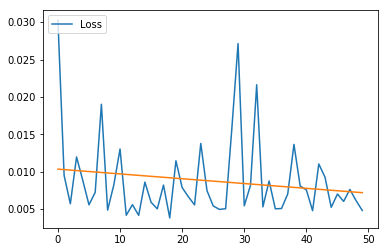

 
Training duration (min) :  66.05245176951091
Weights saved.
Average MSE:  644.1179953987564


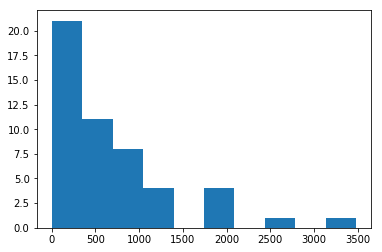

Epoch 1/1
50/50 [==============================] - 4011s 80s/step - loss: 0.0081
Loss History:


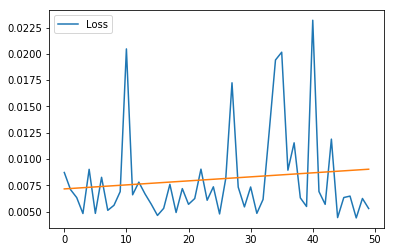

 
Training duration (min) :  66.85717258453369
Weights saved.
Average MSE:  803.066555430994


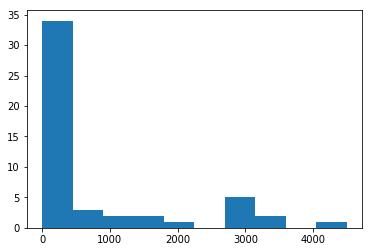

Epoch 1/1
50/50 [==============================] - 3938s 79s/step - loss: 0.0073
Loss History:


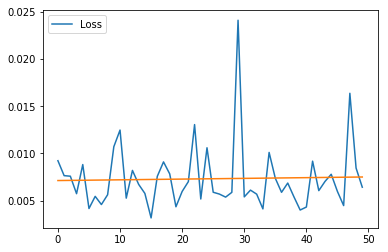

 
Training duration (min) :  65.64200017849605
Weights saved.
Average MSE:  842.7052400883197


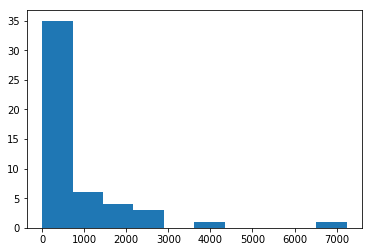

Epoch 1/1
50/50 [==============================] - 4129s 83s/step - loss: 0.0082
Loss History:


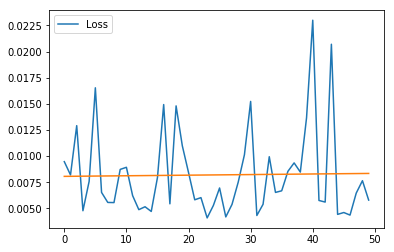

 
Training duration (min) :  68.83066429297129
Weights saved.
Average MSE:  1058.1095096187616


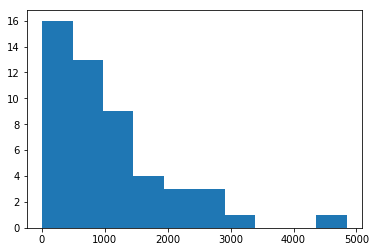

Epoch 1/1
50/50 [==============================] - 4131s 83s/step - loss: 0.0071
Loss History:


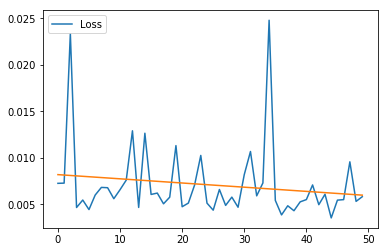

 
Training duration (min) :  68.85295554399491
Weights saved.
Average MSE:  779.5386510910699


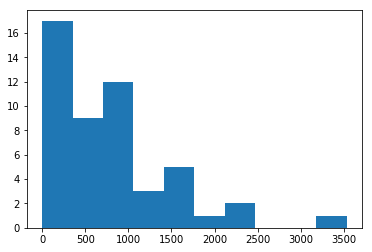

In [12]:
model.load_weights('rnn_weights_74.h5')

for j in range(5):
    
    global_start_time = time.time()
    
    x_train_batch, y_train_batch = get_batch(50)
    history = LossHistory()
    model.fit(x_train_batch,
              y_train_batch,
              batch_size=1,
              epochs=1,
              callbacks=[history])
    
    loss = np.array(history.losses)
    coefficients = np.polyfit(np.linspace(0, 1, num=loss.size), loss, 1)
    trendline = coefficients[0]*(np.linspace(0, 1, num=loss.size)) + coefficients[1]
    
    print("Loss History:")
    plt.plot(loss, label = 'Loss')
    plt.legend(loc='upper left')
    plt.plot(trendline)
    plt.show()

    print(" ")
    print('Training duration (min) : ', (time.time() - global_start_time)/60)
    
    num = 80 + j
    model.save_weights("rnn_weights_" + str(num) + ".h5")

    print("Weights saved.")
    
    x_test_batch, y_test_batch = get_batch(50, train=False)
    predicted = model.predict(x_test_batch)
    
    avg_mse = 0
    count_1 = 0
    count_2 = 0
    mse = []
    for i in range(len(y_test_batch)):
        avg_mse += np.square(np.sum(y_test_batch[i] - predicted[i]))
        mse.append(np.square(np.sum(y_test_batch[i] - predicted[i])))
    
    print("Average MSE: ", avg_mse / len(y_test_batch))
    plt.hist(mse)
    plt.show()

In [13]:
x_test_batch, y_test_batch = get_batch(50, train=False)
predicted = model.predict(x_test_batch)

Average MSE:  1033.5171013867791


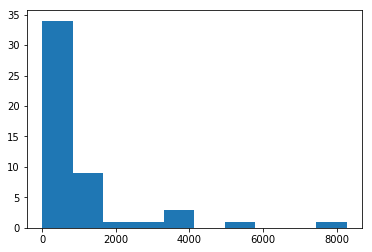

 
Total number of test waves: 50
Number of waves with MSE < 0.5: 1
Number of waves with MSE > 100: 37


In [14]:
avg_mse = 0
count_1 = 0
count_2 = 0
mse = []
for i in range(len(y_test_batch)):
    avg_mse += np.square(np.sum(y_test_batch[i] - predicted[i]))
    mse.append(np.square(np.sum(y_test_batch[i] - predicted[i])))
    if np.square(np.sum(y_test_batch[i] - predicted[i])) > 100:
        count_2 += 1
    elif np.square(np.sum(y_test_batch[i] - predicted[i])) < 0.5:
        count_1 += 1
    
print("Average MSE: ", avg_mse / len(y_test_batch))
plt.hist(mse)
plt.show()
print(" ")
print("Total number of test waves: " + str(len(x_test_batch)))
print("Number of waves with MSE < 0.5: " + str(count_1))
print("Number of waves with MSE > 100: " + str(count_2))

A Sample of the Results:
MSE:  623.3251714489788


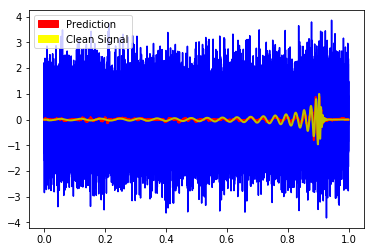

MSE:  359.7143396847527


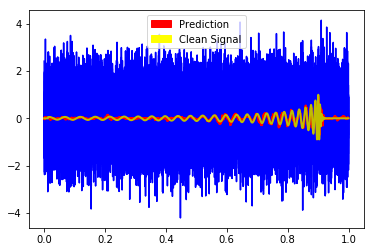

MSE:  1398.3856447467995


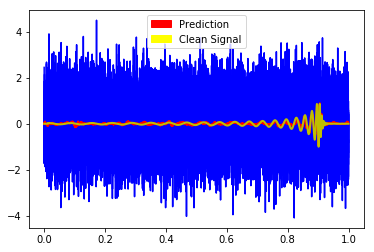

MSE:  793.7861551532307


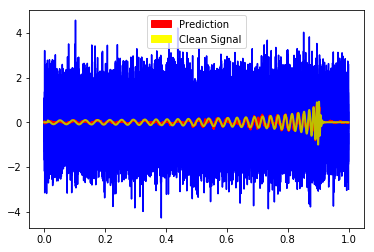

MSE:  558.6556624381265


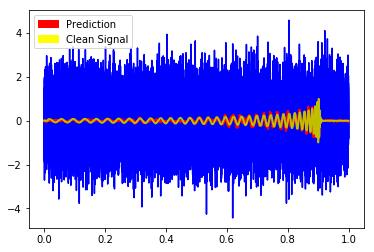

In [15]:
print("A Sample of the Results:")

indices = [3, 4, 6, 7, 13]

for n in indices:
    print("MSE: ", np.square(np.sum(y_test_batch[n] - predicted[n])))
    plt.plot(t, x_test_batch[n], "b-", label='Noisy Signal')
    plt.plot(t, predicted[n], "r-", label='Prediction', linewidth=2.0)
    plt.plot(t, y_test_batch[n], "y-", label='True Data', linewidth=2.0)
    red_patch = mpatches.Patch(color='red', label='Prediction')
    yellow_patch = mpatches.Patch(color='yellow', label='Clean Signal')
    plt.legend(handles=[red_patch, yellow_patch])
    plt.show()